In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline
import skopi as sk
import numpy as np
import os, time
import scipy.ndimage
import skopi.gpu as pg
from skopi.aggregate import build_bpca
from skopi.particlePlacement import *
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
import matplotlib.patches as patches

#### Fig. S1 -- hydration

In [2]:
args = dict()
args['pdb_file'] = "/sdf/home/a/apeck/skopi/examples/input/pdb/3iyf.pdb"
args['beam_file'] = "/sdf/home/a/apeck/skopi/examples/input/beam/amo86615.beam"
args['geom_file'] = "/sdf/home/a/apeck/skopi/examples/input/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data"
args['increase_factor'] = 1e3

In [3]:
# generate beam
beam = sk.Beam(args['beam_file'])
beam.set_photons_per_pulse(args['increase_factor']*beam.get_photons_per_pulse())

# generate detector
det = sk.PnccdDetector(geom=args['geom_file'], beam=beam)
det.distance = 0.2

In [4]:
images, atom_pos, water_pos = dict(), dict(), dict()
mesh_voxel_size = 2.0 / 10**10

for hlt in [0,4,8,12]:
    # generate particle
    particle = sk.Particle()
    particle.read_pdb(args['pdb_file'], ff='WK')
    atom_pos[hlt] = np.ascontiguousarray(particle.atom_pos[:])
    
    if hlt != 0:
        hydration_layer_thickness = hlt / 10**10
        particle.set_hydration_layer_thickness(hydration_layer_thickness)
        particle.set_mesh_voxel_size(mesh_voxel_size)
        particle.create_masks()
        water_pos[hlt] = np.ascontiguousarray(particle.mesh[particle.solvent_mask,:])

    images[hlt] = det.assemble_image_stack(det.get_photons(particle))
    #images[hlt] = det.assemble_image_stack(det.get_intensity_field(particle))

/opt/anaconda/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


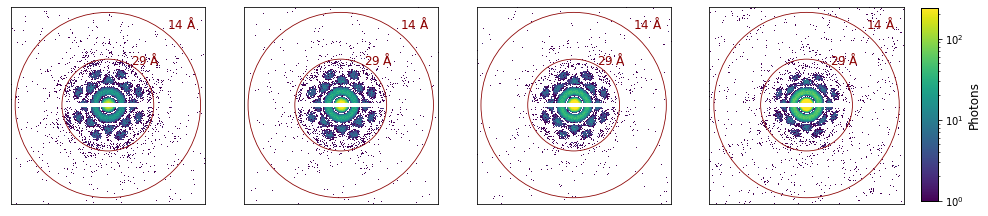

In [41]:
s_mags = det.assemble_image_stack(det.pixel_distance_reciprocal)

f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(16,4))

norm = matplotlib.colors.LogNorm(vmin=1, vmax=images[0].max())
for hlt,ax in zip([0,4,8,12],[ax1,ax2,ax3,ax4]):
    im = ax.imshow(images[hlt].T, origin='lower', interpolation='None', norm=norm) #, vmax=15*np.mean(images[0]))
    ax.set_xticks([])
    ax.set_yticks([])
    
    # add diffraction rings
    center = 0.5*np.array(images[hlt].T.shape)[::-1]
    s_start = s_mags.max() * 0.68
    steps = range(1,3)
    for i in steps:
        q = i*s_start/steps[-1]
        s = q/(2*beam.wavenumber)
        pix_rad = det.distance * 2 * s * np.sqrt(1-s**2) / (1-2*s**2) / np.mean(det.pixel_width)
        resolution = 1e10/q
        label_pos = 0.85*(1-0.03*i)

        ax.add_patch(Circle(center, pix_rad, edgecolor='darkred', fill=False, linewidth=0.8))
        ax.annotate("%i $\mathrm{\AA}$"%resolution, xy=(label_pos*pix_rad+center[0], label_pos*pix_rad+center[1]),
                               ha="center", va="bottom", color="darkred", fontsize=12)
        
    cbar_ax = f.add_axes([0.915, 0.17, 0.015, 0.67])
    cb = f.colorbar(im, cax=cbar_ax)
    cb.set_label("Photons", fontsize=12)
    #rect = patches.Rectangle((0,512), 1045, 20, facecolor='white')
    #ax.add_patch(rect)
    #ax.axis('off')
    
f.savefig("/sdf/home/a/apeck/exafel/skopi_figs/hydration/patterns_logphot.png", bbox_inches='tight', dpi=300)

In [ ]:
#### alternate approach for retrieving pix_radius corresponding to different resolutions / s_mags
x,y = np.meshgrid(np.arange(s_mags.shape[1]),np.arange(s_mags.shape[0]))
x -= int(s_mags.shape[1]/2)
y -= int(s_mags.shape[0]/2)
R = np.sqrt(x**2+y**2)

slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(s_mags[s_mags!=0],R[s_mags!=0])
recip_pixel_width = 1.0/det.pixel_width[0][0][0]

s_start = s_mags.max() * 0.8
#for i in range(1,4):
    #print(i*s_start/steps[-1] * slope + intercept, 1e10/(i*s_start/steps[-1]))

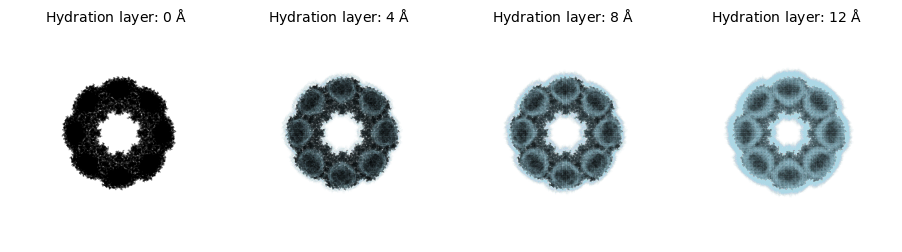

In [44]:
f = plt.figure(figsize=plt.figaspect(0.25))

for i,hlt in enumerate([0,4,8,12]):
    ax = f.add_subplot(1,4,i+1,projection='3d')
    ax.scatter(atom_pos[hlt][:,0], atom_pos[hlt][:,1], atom_pos[hlt][:,2], s=0.05, c='black')
    if hlt!=0:
        ax.scatter(water_pos[hlt][:,0], water_pos[hlt][:,1], water_pos[hlt][:,2], s=0.05, c='lightblue', alpha=0.1)
    ax.view_init(90,0)
    ax.axis('off')
    
    ax.set_xlim(-1e-8, 1e-8)
    ax.set_ylim(-1e-8, 1e-8)
    ax.set_zlim(-1e-8, 1e-8)
    ax.set_title("Hydration layer: %i $\mathrm{\AA}$" %hlt, fontsize=14)
    
f.subplots_adjust(wspace=0.005)
f.savefig("/sdf/home/a/apeck/exafel/skopi_figs/hydration/proteins.png", bbox_inches='tight', dpi=300)

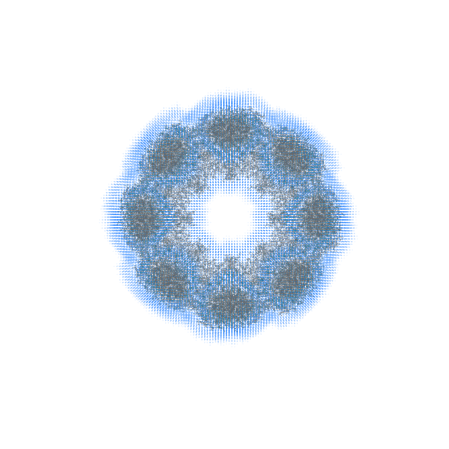

In [48]:
hlt = 12
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(projection='3d')

ax.scatter(atom_pos[hlt][:,0], atom_pos[hlt][:,1], atom_pos[hlt][:,2], s=0.05, c='dimgrey')
if hlt!=0:
    ax.scatter(water_pos[hlt][:,0], water_pos[hlt][:,1], water_pos[hlt][:,2], s=0.05, c='dodgerblue', alpha=0.1)
ax.view_init(90,0)

ax.set_xlim(-1e-8, 1e-8)
ax.set_ylim(-1e-8, 1e-8)
ax.set_zlim(-1e-8, 1e-8)

ax.axis('off')
f.savefig("/sdf/home/a/apeck/exafel/skopi_figs/hydration/prot_%iA.png" %hlt, bbox_inches='tight', dpi=300)

#### Fig. S1 -- normal modes

In [3]:
# generate beam
beam = sk.Beam(args['beam_file'])
beam.set_photons_per_pulse(args['increase_factor']*beam.get_photons_per_pulse())

# generate detector
det = sk.PnccdDetector(geom=args['geom_file'], beam=beam)
det.distance = 0.2

In [4]:
variances = np.load("/sdf/home/a/apeck/exafel/skopi_figs/conformations/normal_mode_variances.npy")
vectors = np.load("/sdf/home/a/apeck/exafel/skopi_figs/conformations/normal_mode_vectors.npy")

In [5]:
particle = sk.Particle()
particle.read_pdb(args['pdb_file'], ff='WK')
particle.num_normal_modes = len(variances)

In [6]:
particle.normal_mode_vectors = vectors.reshape(particle.atom_pos.shape[0],
                                               particle.atom_pos.shape[1],
                                               particle.num_normal_modes)
particle.normal_mode_variances = variances

In [16]:
atom_pos, images = dict(), dict()
for i in range(4):
    if i!=0:
        particle.atom_pos = particle.update_conformation()
    atom_pos[i] = particle.atom_pos.copy()
    images[i] = det.assemble_image_stack(det.get_intensity_field(particle))

Text(0.5, 1.0, 'Difference map')

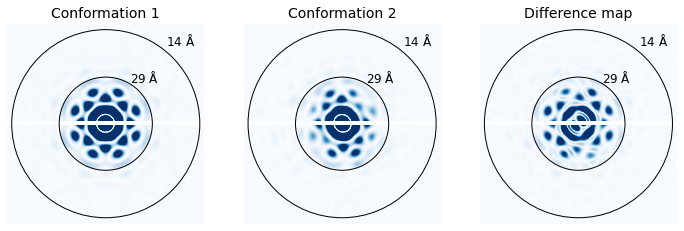

In [68]:
s_mags = det.assemble_image_stack(det.pixel_distance_reciprocal)

f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,4))

ax1.imshow(images[0].T, origin='lower', interpolation='None', vmax=5*np.mean(images[0]), cmap='Blues') 
ax2.imshow(images[3].T, origin='lower', interpolation='None', vmax=5*np.mean(images[0]), cmap='Blues') 
ax3.imshow(np.abs(images[3].T - images[0].T), origin='lower', interpolation='None', cmap='Blues',vmax=5*np.mean(images[0])) 


for i,ax in enumerate([ax1,ax2,ax3]):
    ax.set_xticks([])
    ax.set_yticks([])
    
    rect = patches.Rectangle((0,512), 1045, 20, facecolor='white')
    ax.add_patch(rect)
    ax.axis('off')
    
    # add diffraction rings
    center = 0.5*np.array(images[0].T.shape)[::-1]
    s_start = s_mags.max() * 0.68
    steps = range(1,3)
    for i in steps:
        q = i*s_start/steps[-1]
        s = q/(2*beam.wavenumber)
        pix_rad = det.distance * 2 * s * np.sqrt(1-s**2) / (1-2*s**2) / np.mean(det.pixel_width)
        resolution = 1e10/q
        label_pos = 0.85*(1-0.03*i)

        ax.add_patch(Circle(center, pix_rad, edgecolor='black', fill=False))
        ax.annotate("%i $\mathrm{\AA}$"%resolution, xy=(label_pos*pix_rad+center[0], label_pos*pix_rad+center[1]),
                               ha="center", va="bottom", color="black", fontsize=12)
        
ax1.set_title("Conformation 1", fontsize=14)
ax2.set_title("Conformation 2", fontsize=14)
ax3.set_title("Difference map", fontsize=14)

In [8]:
atom_pos, images = dict(), dict()
for i in range(4):
    if i!=0:
        particle.atom_pos = atom_pos[0].copy() # reset to ideal positions
        particle.atom_pos = particle.update_conformation(rmsd=3)
    atom_pos[i] = particle.atom_pos.copy()
    images[i] = det.assemble_image_stack(det.get_photons(particle))

/opt/anaconda/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


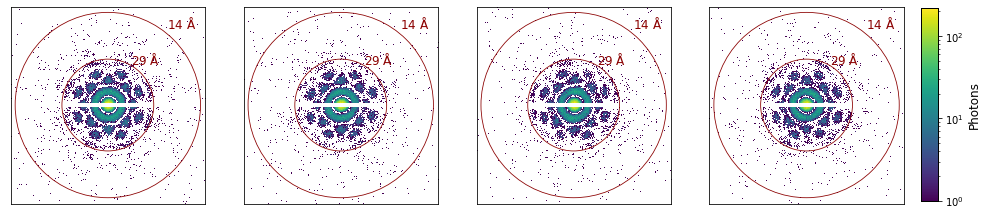

In [18]:
s_mags = det.assemble_image_stack(det.pixel_distance_reciprocal)

f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(16,4))

norm = matplotlib.colors.LogNorm(vmin=1, vmax=images[0].max())
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    im = ax.imshow(images[i].T, origin='lower', interpolation='None', norm=norm)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # add diffraction rings
    center = 0.5*np.array(images[0].T.shape)[::-1]
    s_start = s_mags.max() * 0.68
    steps = range(1,3)
    for i in steps:
        q = i*s_start/steps[-1]
        s = q/(2*beam.wavenumber)
        pix_rad = det.distance * 2 * s * np.sqrt(1-s**2) / (1-2*s**2) / np.mean(det.pixel_width)
        resolution = 1e10/q
        label_pos = 0.85*(1-0.03*i)

        ax.add_patch(Circle(center, pix_rad, edgecolor='darkred', fill=False, linewidth=0.8))
        ax.annotate("%i $\mathrm{\AA}$"%resolution, xy=(label_pos*pix_rad+center[0], label_pos*pix_rad+center[1]),
                               ha="center", va="bottom", color="darkred", fontsize=12)
        
    cbar_ax = f.add_axes([0.915, 0.17, 0.015, 0.67])
    cb = f.colorbar(im, cax=cbar_ax)
    cb.set_label("Photons", fontsize=12)
    #rect = patches.Rectangle((0,512), 1045, 20, facecolor='white')
    #ax.add_patch(rect)
    #ax.axis('off')

f.savefig("/sdf/home/a/apeck/exafel/skopi_figs/conformations/patterns_logphot.png", bbox_inches='tight', dpi=300)

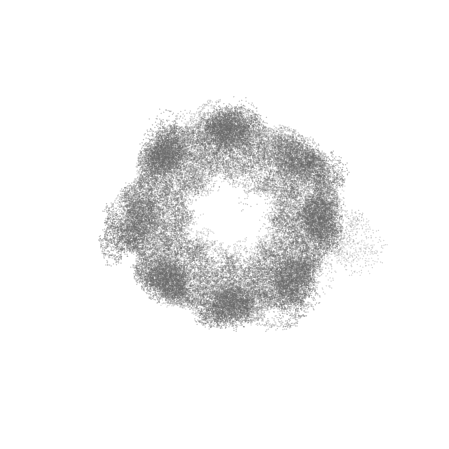

In [17]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(projection='3d')

hlt=3
ax.scatter(atom_pos[hlt][:,0], atom_pos[hlt][:,1], atom_pos[hlt][:,2], s=0.05, c='dimgrey')
ax.view_init(90,0)

ax.set_xlim(-1e-8, 1e-8)
ax.set_ylim(-1e-8, 1e-8)
ax.set_zlim(-1e-8, 1e-8)

ax.axis('off')
f.savefig("/sdf/home/a/apeck/exafel/skopi_figs/conformations/prot_c%i.png" %hlt, bbox_inches='tight', dpi=300)